In [1]:
# use lod env
import pandas as pd
import ast
import shapely
import geopandas as gpd
import matplotlib.pyplot as plt
import numpy as np
from mpl_toolkits.mplot3d.art3d import Poly3DCollection
from shapely.geometry import Polygon, MultiPolygon, LineString
import random

## Calculate features from LoD2 data

These include:
* area in m²
* normal (east/north/height coordinates): the normal of the surface standing in a right angle to the wall and showing in the exterior direction of the wall.
* ground_bound (True/False): whether or not the wall has an edge on the ground. 
* orientation (as degrees to the north vector and the approximate cardinal direction)
* visible/outside surface (its area in m² and its coordinates, as well as the wall_ids that were subtracted from the total wall)

This is done by:
1. Reading data in
2. Calculating area and removing all walls with 0m² area
3. Calculating normals for each wall and checking whether the walls are vertical -> if not, they are removed
4. Combining walls that share an edge and have the same normal direction
5. Checking whether the walls are groundbound (having an edge on the ground) and removing all others
6. Calculating the wall height
7. Calculating orientation and cardinal direction
8. Calculating outside factors: outside_surface_coordinates, outside_area, outside_subtracted_walls, outside, outside_groundbound, outside_bounding_box

### 1. Reading data in

In [2]:
# important paths
data_dir = "./../../data"
dataframes_dir = data_dir + "/dataframes"

# read data in
df1_parts = pd.read_csv(dataframes_dir + "/df1_parts.csv")
df2_walls = pd.read_csv(dataframes_dir + "/df2_walls_00.csv")

# change type: make lists out of strings in surface columns
df1_parts["ground_surface"] = df1_parts["ground_surface"].apply(ast.literal_eval)
df2_walls["surface_coordinates"] = df2_walls["surface_coordinates"].apply(ast.literal_eval)

print("Columns of df1_parts:", df1_parts.columns)
print("Columns of df2_walls:", df2_walls.columns)

Columns of df1_parts: Index(['building_id', 'part_id', 'has_building_parts', 'is_part', 'street',
       'house_nr', 'hnr_add', 'district', 'roof_form', 'building_height',
       'ground_surface'],
      dtype='object')
Columns of df2_walls: Index(['part_id', 'wall_id', 'surface_coordinates'], dtype='object')


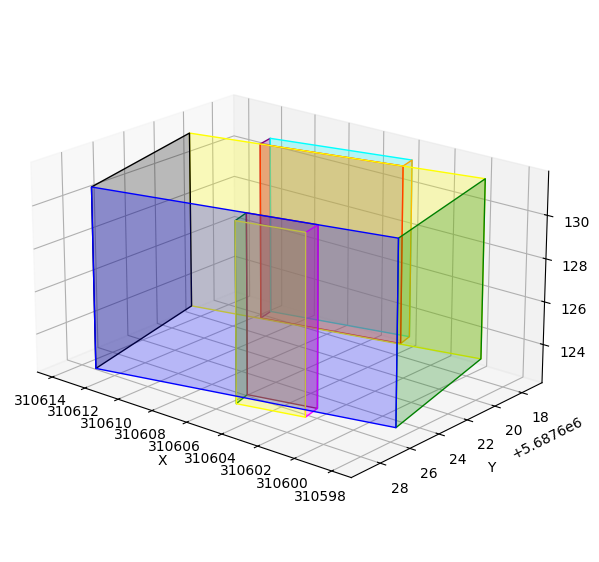

In [3]:
# function for plotting walls
def plot_walls(list_of_wall_coords, print_corner_nrs = False, print_wall_nr = False, view_elev = 20, view_azim = -45, figsize = (10,10)):
    """ 
    Function that takes a list of walls (each wall being a list of 3d-coordinate tuples) and plots those

    PARAMS:
    * list_of_wall_coords (list of lists of 3d tuples): list of surfaces, each being a list of coordinate tuples
    * print_corner_nrs (boolean): True if index of the corners of each wall should be included in plot
    * print_wall_nr (boolean): True if index of wall in list_of_wall_coords should be included in plot
    * view_elev, view_azim (int/float): parameters for plt plot concerning the view angle
    * figsize (2d-tuple): size of plt figure
    """
    fig = plt.figure(figsize=figsize)
    ax = fig.add_subplot(111, projection='3d')
    colors = ["yellow", "green", "blue", "black", "purple", "cyan", "orange", "red", "brown", "magenta"]

    # set limits according to wall coordinates, initialize limits here
    xmin, ymin, zmin = -1,-1,-1
    xmax, ymax, zmax = -1,-1,-1

    for index, wall in enumerate(list_of_wall_coords):
        # create a plottable poly for this wall
        coords = np.array(wall)
        poly3d = Poly3DCollection([coords], alpha=.25, linewidths=1, edgecolors=colors[index%len(colors)], facecolors = colors[index%len(colors)])

        # change limit values of plot if necessary
        xmin_, ymin_, zmin_ = np.min(coords, axis = 0)
        xmax_, ymax_, zmax_ = np.max(coords, axis = 0)
        if xmin == -1:
            xmin, ymin, zmin = xmin_, ymin_, zmin_
            xmax, ymax, zmax = xmax_, ymax_, zmax_
        xmin = min(xmin, xmin_)
        ymin = min(ymin, ymin_)
        zmin = min(zmin, zmin_)
        xmax = max(xmax, xmax_)
        ymax = max(ymax, ymax_)
        zmax = max(zmax, zmax_)

        # Add the polygon to the plot
        ax.add_collection3d(poly3d)

        if print_corner_nrs:
            # plot corner indices next to corners
            for corner_nr, pos in enumerate(coords):
                ax.text(pos[0] + random.random() - 0.5, 
                        pos[1]  + random.random() - 0.5, 
                        z = pos[2] + random.random() - 0.5, s = corner_nr, color = colors[index%len(colors)], size = 15)
        
        if print_wall_nr:
            # print wall indices on wall
            ax.text(x = np.mean([xmin_, xmax_]),
                    y = np.mean([ymin_, ymax_]),
                    z = np.mean([zmin_, zmax_]), s = index, color = colors[index%len(colors)], size = 15)

    ax.set_xlim([xmin - 0.5, xmax + 0.5])
    ax.set_ylim([ymin - 0.5, ymax + 0.5])
    ax.set_zlim([zmin - 0.5, zmax + 0.5])

    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Z')

    ax.set_aspect('equal')

    # viewing angle and elevation
    ax.view_init(elev=view_elev, azim=view_azim) 

    plt.show()

# join df1 and df2 in order to plot all walls of one building id (id not included in df2)
df1_df2_join = pd.merge(df1_parts, df2_walls, on = "part_id", how = "right")

# get all walls from a special building id or part id and plot
building_id = "DESN_0000FI2"
walls_for_given_building_id = df1_df2_join[df1_df2_join["building_id"] == building_id]["surface_coordinates"]

part_id = "DESN_00061EM_main"
walls_for_given_part_id = df2_walls[df2_walls["part_id"] == part_id]["surface_coordinates"] 

plot_walls(list(walls_for_given_building_id), print_wall_nr=False, view_azim = 130, figsize = (7, 10))

### 2. Compute Area of walls and remove those with 0m² area
This leads to less problems with the computation of the following factors

In [4]:
# approximate runtime 2-3 min
df2_walls["area"] = 0.0

# for each wall, extract coordinates and use cross product method to calculate area with 3d coordinates
for index, row in df2_walls.iterrows():
    # get coords, but ignore the last coordinate tuple as it is the same as the first one and not needed here
    coords = np.array(row["surface_coordinates"])[:-1]
    area = 0
    # use cross product method to calculate area (the area calculation of shapely does not deal well with 3d coords)
    for i in range(1, len(coords)-1):
        # always computes the area of the triangle between coords[0], coords[i] and coords[i+1]
        v1 = coords[i] - coords[0]
        v2 = coords[i+1] - coords[0]
        cross_prod = np.cross(v1,v2)
        area += np.linalg.norm(cross_prod) / 2
    # save calculated area in according row
    df2_walls.at[index, "area"] = area

In [7]:
# delete all walls with 0 m² area
before = len(df2_walls)
print(before, "wall surfaces before")
df2_walls = df2_walls[df2_walls["area"] > 0].reset_index(drop = True)
print(len(df2_walls), "after deleting walls with no area;", before - len(df2_walls), "walls removed")

1084285 wall surfaces before
1084234 after deleting walls with no area; 51 walls removed


### 3. Calculate normals for each wall and check whether they are vertical

Normal vectors show in direction of the exterior of the building. Walls that are not vertical (absolute value of z-value of normalized normal vector higher 0.05, which means that from a 1m-long vector, the vector goes more than 5cm down/up), will be deleted. Value of 0.05 is chosen arbitrarily.

In [8]:
def get_normalized_normal_vector(coords, counter = None):
    """
    Get a list of coordinate tuples (in 3d) of a wall and calculate the normal vector, showing to the exterior of the building. Normalize vector to length 1m. This function uses the fact that the wall coordinates are in counterclockwise order when seeing the wall from outside the building.
    Return normalized normal vector and a counter which was increased if the vector had length 0, which should not happen

    PARAMS:
    * coords (list of 3d-tuples): coordinate tuples of a wall, should at least have 3 coordinates
    * counter (int): is increased by one if the resulting normal vector has a length of 0

    RETURNS:
    * normalized_normal_vector: normal vector with length 1
    * counter: either None (if no counter or None was given in), or inputted counter (+1 if normal vector has length 0)
    """
    # take first three coordinates to compute normal vector
    coords = np.array(coords)
    v1 = coords[0] - coords[1]
    v2 = coords[0] - coords[2]

    # get the normalized (scaled to length 1) normal vector (showing into direction of facade wall outside) 
    # |Building|->
    normal_vector = np.cross(v1, v2)
    if np.linalg.norm(normal_vector) != 0:
        normalized_normal_vector = normal_vector / np.linalg.norm(normal_vector)
        return normalized_normal_vector, counter
    # if length is 0, we did not have a triangle before with coords 0,1,2
    else:
        if counter is not None:
            counter += 1
        return np.array([0,0,0]), counter


In [9]:
# count normal vectors with length 0 (should only happen if data has duplicates, areas with 0m² and so on)
counter = 0
df2_walls["normal_vec"] = [[] for _ in range(len(df2_walls))] 
df2_walls["vertical"] = False

for index, row in df2_walls.iterrows():
    coords = np.array(row["surface_coordinates"])
    normalized_normal_vector, counter = get_normalized_normal_vector(coords, counter)
    # save normal vector
    df2_walls.at[index, "normal_vec"] = list(normalized_normal_vector)
    # check whether in will be considered as vertical: for 1m long normal vector, if it goes up or down more than 5cm its not vertical
    if np.abs(normalized_normal_vector[2]) <= 0.05:
        df2_walls.at[index, "vertical"] = True

print(counter, "vectors that have a cross product of 0")

0 vectors that have a cross product of 0


In [10]:
# delete all walls that are not vertical
before = len(df2_walls)
print(before, "wall surfaces before")
df2_walls = df2_walls[df2_walls["vertical"]].reset_index(drop = True)
print(len(df2_walls), "after deleting non-vertical walls;", before - len(df2_walls), "walls removed")

# delete column vertical
df2_walls = df2_walls.drop("vertical", axis = 1) # 1084234 -> 1084062

1084234 wall surfaces before
1084062 after deleting non-vertical walls; 172 walls removed


### 4. Combining walls that share an edge and have the same normal direction

In [11]:
def get_angle_0_to_180(vec1, vec2):
    '''
    Takes two vectors (2d or 3d) and computes the angle in degrees between both. Order of the vectors does not matter

    PARAMS:
    * vec1, vec2 (2d or 3d tuples): vectors between which the angle should be calculated
    '''
    vec1 = np.array(vec1)
    vec2 = np.array(vec2)
    
    # Calculate the dot product
    dot_product = np.dot(vec1, vec2)
    
    # Calculate the magnitudes of the vectors
    magnitude_a = np.linalg.norm(vec1)
    magnitude_b = np.linalg.norm(vec2)
    
    # Calculate the cosine of the angle
    if magnitude_a * magnitude_b != 0:
        cos_theta = np.clip(dot_product / (magnitude_a * magnitude_b), -1, 1)
    else:  # if both magnitudes multiplied are 0, one of them needs to be 0 -> check this!
        print("vec1:", vec1)
        print("vec2:", vec2)
        print("Magnitude_a:", magnitude_a)
        print("Magnitude_b:", magnitude_b)
        return 0
    
    # Calculate the angle in radians
    angle_radians = np.arccos(cos_theta)
    
    # Convert the angle to degrees
    angle_degrees = np.degrees(angle_radians)
    
    return angle_degrees


def check_if_same_line(corner1, corner2, corner3):
    '''
    Takes three coordinates tuples and checks whether they lie on the same 3D line and where the corner3 lies in respect to the others

    PARAMS:
    * corner1, corner2 (3d tuples): two consecutive coordinate tuples of first wall
    * corner3 (3d tuple): coordinate tuples of second wall

    RETURNS:
    * whether all three corners lie on the same 3D line (boolean)
    * scaling_factor: corner3 - corner1 / corner2 - corner1. If the factor is positive but below 1, corner3 is between both other corners on the line  corner1--corner3--corner2. If it is negative, corner3 is before corner1 corner3--corner1--corner2. Above 1: corner1--corner2--corner3
    '''
    if ((corner2[1] - corner1[1]) * (corner3[0] - corner1[0])) == ((corner3[1] - corner1[1]) * (corner2[0] - corner1[0])):
        if ((corner2[2] - corner1[2]) * (corner3[0] - corner1[0])) == ((corner3[2] - corner1[2]) * (corner2[0] - corner1[0])):
            if (corner2[0] - corner1[0]) != 0:
                scaling_factor = (corner3[0] - corner1[0])/(corner2[0] - corner1[0])
            elif (corner2[1] - corner1[1]) != 0:
                scaling_factor = (corner3[1] - corner1[1])/(corner2[1] - corner1[1])
            elif (corner2[2] - corner1[2]) != 0:
                scaling_factor = (corner3[2] - corner1[2])/(corner2[2] - corner1[2])
            else:
                "corner1 and corner2 are the same!" # should normally not happen, were removed already
                return False, 0
            return True, scaling_factor
        
    return False, 0


def common_edge(wall1_coordinates, wall2_coordinates):
    """ 
    check for two walls whether they have a common edge 
    1. check whether both walls have consecutive corners in common (mostly the case)
    2. check if two consecutive corners of each wall lie on the same 3D line and the line segments intersect each other

    PARAMS:
    * wall1_coordinates: a list of tuples with (x,y,z)-coordinates, last one = first one, for first wall
    * wall2_coordinates: a list of tuples with (x,y,z)-coordinates, last one = first one, for second wall

    RETURNS:
    boolean, whether both walls have a common edge
    """
    wall1 = np.array(wall1_coordinates)
    wall2 = np.array(wall2_coordinates)

    # check whether both walls have two consecutive corners in common 
    for corner_index in range(len(wall1[:-1,:])):
        for corner_index2 in range(1,len(wall2[:,:])):
            if np.all(wall1[corner_index] == wall2[corner_index2]):
                if np.all(wall1[corner_index + 1] == wall2[corner_index2 - 1]):
                    return True

    # else check if one edge is partly in common (two points of each wall on the same 3d line in space and with an intersection in between)
    for corner_index in range(0,len(wall1[:-1,:])):
        for corner_index2 in range(1,len(wall2)):
            first_point_on_line, scaling_factor1 = check_if_same_line(wall1[corner_index], wall1[corner_index+1], wall2[corner_index2])
            if first_point_on_line:
                second_point_on_line, scaling_factor2 = check_if_same_line(wall1[corner_index], wall1[corner_index+1], wall2[corner_index2-1])
                if second_point_on_line:
                    # check whether one of the points from wall2 is between both points of wall1 (scaling factor between 0 and 1)
                    if 0 <= scaling_factor1 <= 1 or 0 <= scaling_factor2 <= 1:
                        return True
                    # if not, the possibility is still that wall1 is completely in between the two wall2 points
                    if (scaling_factor1 < 0 and scaling_factor2 > 0) or (scaling_factor1 > 0 and scaling_factor2 < 0):
                        return True
                    
    return False


def check_for_id_in_to_join(wall_id, to_join, part_id):
    ''' 
    search through all walls of this part that are already being joined for wall_id.
    If it is already in there, return index in to_join

    PARAMS:
    * wall_id (str): which wall to search for
    * to_join (df): df with three columns: part_id, wall_id_list (walls that are already to join), new_id (for new, joined wall). Each row will be joined to one wall. Can have several rows per part_id
    * part_id (str): which part the wall is in (significantly speeds up the process to search for it)

    RETURNS:
    * whether the wall_id is already in any of the to_join rows 
    * indx_nr: index of the row it is in
    '''
    # filter to_join for only those rows concerning the given part_id
    to_join_for_this_part = to_join[to_join["part_id"] == part_id]
    # search in those for wall_id
    for indx_nr, row in to_join_for_this_part.iterrows():
        if wall_id in row["wall_id_list"]:
            return True, indx_nr
        
    return False, 0

In [12]:
# runs about 45 min
# search for those walls of the same part that have an adjacent edge and the approximately same normal -> these walls will be joined in a later step. It can be several walls (more than two) that fulfill these requirements (these can be chained, wall1 and wall2 should be joined and wall2 and wall3 --> join all three walls) and can be joined.

grouped_by_part = df2_walls.groupby("part_id").agg(
    coordinates=('surface_coordinates', lambda x: list(x)), 
    normals = ("normal_vec", lambda x: list(x)),
    wall_ids = ("wall_id", lambda x: list(x))        
).reset_index()

# initialize df for which walls to join. For each pair or group of walls (all saved as list in wall_id_list) that fulfill the requirements of sharing an edge and having the same normal, save part_id and make up a new_id.
to_join = pd.DataFrame({"part_id": [], "wall_id_list": [], "new_id": []})

count = 0
self_made_id_nr = 0
for index, part in grouped_by_part.iterrows():
    # for each part, check always two walls and whether they fulfill the requirements for a join
    for x, normal_vec1 in enumerate(part["normals"]):
        for y, normal_vec2 in enumerate(part["normals"]):
            if x < y:
                # test whether the normal_vecs are very similar (angle < 1°) 
                angle = get_angle_0_to_180(normal_vec1[0:2], normal_vec2[0:2])
                if (angle < 1):
                    # test whether the walls have a common edge                          
                    if common_edge(part["coordinates"][x], part["coordinates"][y]):
                        count += 1
                        # include in df
                        # three main possibilities:
                        # 1. both walls are not in any wall_id_list tuple -> make new row with new id and everything
                        # 2. one of the walls already is -> add other wall_id to this wall_id_list tuple (no new row)
                        # 3. both walls already are -> join both lists: take the row where wall_x already is and add wall_y plus the other walls in the wall_id_list of wall_y, delete the row where wall_y was present
                        x_in_join, x_id_in_join = check_for_id_in_to_join(part["wall_ids"][x], to_join, part["part_id"])
                        y_in_join, y_id_in_join = check_for_id_in_to_join(part["wall_ids"][y], to_join, part["part_id"])
                        # 1. both walls are not in any wall_id_list tuple
                        if not x_in_join and not y_in_join:
                            new_id = "combined_" + str(self_made_id_nr)
                            self_made_id_nr += 1
                            new_join = pd.DataFrame({
                                "part_id": [part["part_id"]],
                                "wall_id_list": [(part["wall_ids"][x], part["wall_ids"][y])], 
                                "new_id": [new_id]
                                })
                            to_join = pd.concat((to_join, new_join)).reset_index(drop = True)
                        # 2. one of the walls already is
                        elif x_in_join and not y_in_join:
                            wall_id_list_before = to_join.at[x_id_in_join, "wall_id_list"]
                            wall_id_list_after = wall_id_list_before + (part["wall_ids"][y],)
                            to_join.at[x_id_in_join, "wall_id_list"] = wall_id_list_after
                        elif y_in_join and not x_in_join:
                            wall_id_list_before = to_join.at[y_id_in_join, "wall_id_list"]
                            wall_id_list_after = wall_id_list_before + (part["wall_ids"][x],)
                            to_join.at[y_id_in_join, "wall_id_list"] = wall_id_list_after
                        # 3. both walls already are
                        else:
                            wall_id_list_before = to_join.at[x_id_in_join, "wall_id_list"]
                            wall_id_list_after = wall_id_list_before + to_join.at[y_id_in_join, "wall_id_list"]
                            to_join.at[x_id_in_join, "wall_id_list"] = wall_id_list_after
                            # delete other row
                            to_join = to_join.drop(index=y_id_in_join)
                
to_join = to_join.reset_index(drop= True)

print(count, "wall pairs can be joined") #162326

162326 wall pairs can be joined


In [13]:
# save as csv which walls are to join
to_join.to_csv(dataframes_dir + "/to_join.csv", index = False)
to_join #147673

,part_id,wall_id_list,new_id
0,0005IHM_main,"(fme-gen-6646db69-9b74-4b0f-976e-0784b0c24e39,...",combined_0
1,0005IHN_main,"(fme-gen-3792b887-71ce-469d-b432-f40044a642f6,...",combined_1
2,0005IHN_main,"(fme-gen-b0ecacfd-6560-4d84-812a-3cc35a9891be,...",combined_2
3,0005IHN_main,"(fme-gen-3ed805f3-f11e-4f5b-b4ac-92c602228f4d,...",combined_3
4,0005IHO_main,"(fme-gen-b9e610d8-27ab-49b7-9fe7-d6c9d18b54d8,...",combined_4
...,...,...,...
147668,DESN_{FFEE841E-E7EB-40A8-B30D-A6D687B1F3E1}_main,"(fme-gen-7cc6ebdc-ebba-4ff0-90d5-882de404a956,...",combined_148030
147669,DESN_{FFF09CB1-4832-4013-BCA0-B171BB394B1D}_main,"(fme-gen-f8258360-5303-4f50-801e-53c07d88076d,...",combined_148031
147670,DESN_{FFF09CB1-4832-4013-BCA0-B171BB394B1D}_main,"(fme-gen-f3688502-8d90-49ee-ad98-37c8e51d4a1e,...",combined_148032
147671,DESN_{FFF313F9-F3A1-4760-8F91-9C9A4B7F261B}_main,"(fme-gen-83cbe58c-8647-4c27-a74b-62f649931146,...",combined_148033


In [12]:
def make_wall_2d(wall, v1, v2):
    '''
    Projects a 3D wall onto a 2D plane using two vectors.

    PARAMS:
    wall (list of 3d tuples): coordinate tuples (x, y, z) of wall which should be projected
    v1, v2 (3d vectors): both vectors used for projection

    RETURNS:
    wall_2d: A list of 2d tuples representing the projected wall
    '''
    wall_2d = []
    for point in wall:
        x_new = np.dot(v1, np.array(point))
        y_new = np.dot(v2, np.array(point))
        wall_2d.append((x_new, y_new))

    return wall_2d


def make_wall_3d(wall, v1, v2, origin_on_plane):
    '''
    Projects a 2D wall back to 3D plane using both vectors used for 3d-2d projection and the origin_on_plane

    PARAMS:
    wall (list of 2d tuples): coordinate tuples (x, y) of wall which should be projected
    v1, v2 (3d vectors): both vectors used for projection
    origin_on_plane (3d vector): vector pointing from the origin of the 3D space to the origin of the plane where the wall was projected onto

    RETURNS:
    wall_3d: A list of 3d tuples representing the projected wall
    '''
    wall_3d = []
    for point in wall:
        # for each point: sum up vector to origin on plane, both projecting vectors (3d) times the according coordinate from the 2d wall point to get back to the 3d coordinate
        point_3d = tuple(np.round(origin_on_plane + point[0] * v1 + point[1] * v2, 3))
        wall_3d.append(point_3d)

    return wall_3d


def get_joined_surface_of_walls(list_of_surfaces, normal):
    '''
    Joins multiple wall surfaces into a single surface in 3D space.

    This function takes a list of wall surfaces and a normal vector that defines the orientation of the plane
    in which the walls lie. It projects the walls onto a 2D plane, checks if they are coplanar, and then
    combines them into a single polygonal surface. The resulting surface is then transformed back into 3D space.

    PARAMS:
    * list_of_surfaces (list of list of 3d tuple): A list containing surfaces, where each surface is represented
        as a list of 3d tuples
    * normal (3d vector): A tuple representing the normal vector of the plane (a, b, c) to which the walls are aligned.

    RETURNS:
    * bool: True if the surfaces were successfully joined, False otherwise.
    * list: The joined surface in 3D space, or an empty list if joining failed.
    * float: The area of the joined surface, or 0 if joining failed.
    '''
    # project all walls in 2d
    a,b,c = normal
    d = - (a * list_of_surfaces[0][0][0] + b* list_of_surfaces[0][0][1] + c* list_of_surfaces[0][0][2])

    # short check whether the other walls also lie on the plane (not exhaustive, but should catch most of the cases. These should in the best case not happen though)
    for wall2 in list_of_surfaces:
        check_corner1 = a* wall2[0][0] + b*wall2[0][1] + c*wall2[0][2] + d  # should be 0 or close to 0
        check_corner2 = a* wall2[1][0] + b*wall2[1][1] + c*wall2[1][2] + d  # should be 0 or close to 0

        # if not, joining fails
        if np.abs(check_corner1) > 1 or np.abs(check_corner2) > 1:
            return False, [], 0

    # get two vectors, both orthonormal to the normal and to each other, to span the plane
    v1 = np.array(list_of_surfaces[0][0]) - np.array(list_of_surfaces[0][1])
    v1 = v1/np.linalg.norm(v1)
    v2 = np.cross(normal, v1)

    # project all walls to 2d
    list_of_polygons_2d = []
    for surface in list_of_surfaces:
        surface_2d = make_wall_2d(surface, v1, v2)
        list_of_polygons_2d.append(Polygon(surface_2d).buffer(0))

    # join
    joined_surface = shapely.union_all(list_of_polygons_2d)
    area = joined_surface.area

    # get back to 3d again, first need vector pointing from the origin of the 3D space to the origin of the plane where the wall was projected onto
    distance_origin_to_plane = (a * 0 + b * 0 + c * 0 + d) / np.sqrt(a**2 + b**2 + c**2)
    # Project the point onto the plane
    origin_on_plane = [0,0,0] - distance_origin_to_plane * np.array(normal)

    if isinstance(joined_surface, Polygon):
        # make all coordinates of polygon to list of coords again
        joined_surface_coords = list(joined_surface.exterior.coords)
        
    elif isinstance(joined_surface, MultiPolygon):
        # try to make one polygon with buffering
        joined_surface_buffered = shapely.union_all([poly.buffer(0.03, join_style="mitre") for poly in joined_surface.geoms])
        if isinstance(joined_surface_buffered, Polygon):
            joined_surface_coords = list(joined_surface_buffered.exterior.coords)
        else:
            # not joining            
            return False, [], 0
    else:
        # Resulting shape is no polygon or multipolygon, not joining
        return False, [], 0
    
    # back to 3d
    joined_surface_3d = make_wall_3d(joined_surface_coords, v1, v2, origin_on_plane)    

    return True, joined_surface_3d, area


def remove_double_coordinates(df, col_name):
    '''
    Removes duplicate coordinates from a specified column in a DataFrame.

    PARAMS:
    df (pandas.DataFrame): df containing the coordinates row that should be checked for duplicates
    col_name (str): name of the column in the df for which the duplicate coordinates should be removed

    RETURNS:
    df (pandas.DataFrame): modified df with duplicate coordinates removed from the specified column.
    '''
    counter = 0
    for index, row in df.iterrows():
        coords = row[col_name]
        if coords:  # only if list not empty
            coords_new = []
            # append all items that were not already appended before
            [coords_new.append(item) for item in coords if item not in coords_new]
            # always append the first coordinate tuple as the last as well to close the polygon
            coords_new.append(coords[0])
            if coords_new != coords:
                df.at[index, col_name] = coords_new
                counter += 1

    print(counter, "coordinates have been changed")

    return df

In [ ]:
# runs about 6h
before = len(df2_walls)
print(before, "walls before") #1084062

# go through rows in to_join and always save new wall as row in a new dataframe which is appended after the process
joined = to_join.copy()
indices_that_were_not_joined = []
counter_not_joined = 0
new_walls = pd.DataFrame(columns=["part_id", "wall_id", "surface_coordinates", "area", "normal_vec"])
df2_walls_temp = df2_walls.copy()
for index, row in to_join.iterrows():
    if index % 10000 == 0:
        print(index, "/", len(to_join))
    # get a list of the coordinates and corresponding indices from each wall that should be joined
    list_of_wall_coordinates = list(df2_walls[df2_walls["wall_id"].isin(row["wall_id_list"])]["surface_coordinates"])
    list_of_indices = list(df2_walls[df2_walls["wall_id"].isin(row["wall_id_list"])].index)

    # get normal vec of one of the walls in list (in this case its just the first one)
    normal_vec = df2_walls[df2_walls["wall_id"].isin(row["wall_id_list"])]["normal_vec"].values[0]

    # get joined surface
    successfull_join, joined_surface, area = get_joined_surface_of_walls(list_of_wall_coordinates, normal_vec)

    if successfull_join:
        new_walls.loc[index] = [row["part_id"], row["new_id"], joined_surface, area, normal_vec]

        # remove all walls from df that were just joined (to make sure the same wall will not be used again)
        df2_walls_temp = df2_walls_temp.drop(list_of_indices)
    else:
        # join not successfull: make sure that row is deleted from joined in the end
        indices_that_were_not_joined.append(index)
        counter_not_joined += 1
        
# delete duplicate coordinates
new_walls = remove_double_coordinates(new_walls, "surface_coordinates")

print("Start deleting old walls and concatenate new walls")

df2_walls = pd.concat((df2_walls_temp, new_walls)).reset_index(drop = True)

joined = joined.drop(indices_that_were_not_joined)

print("Dataframes joined successfully")

print(len(df2_walls), "after joining walls;", before - len(df2_walls), "walls less")
print(counter_not_joined, "joins were not successful and therefor not performed")


1084062 walls before
0 / 147673
10000 / 147673
20000 / 147673
30000 / 147673
40000 / 147673
50000 / 147673
60000 / 147673
70000 / 147673
80000 / 147673
90000 / 147673
100000 / 147673
110000 / 147673
120000 / 147673
130000 / 147673
140000 / 147673
90 coordinates have been changed
Start deleting old walls and concatenate new walls
Dataframes joined successfully
922439 after joining walls; 161623 walls less
27 joins were not successful and therefor not performed


In [16]:
df2_walls.to_csv(dataframes_dir + "/df2_walls_01_after_wall_merging.csv", index = False)
joined.to_csv(dataframes_dir + "/joined_walls.csv", index = False)

### 5. Check whether the walls are groundbound (having an edge on the ground) and remove all others

In [6]:
def at_least_two_on_ground(wall_coords, ground_coords):
    ''' 
    for a list of coordinates (belonging to a wall) and a minimum and maximum value (representing the ground values, extracted from ground_coords) this function checks whether to at least two coordinates of the wall are in the range from minimum to maximum value (ergo on the ground)

    PARAMS:
    * wall_coords (list of 3d tuples): wall coordinate tuples which are checked whether two are on ground
    * ground_coords (list of 3d tuples): ground surface coordinates, used to get minimum and maximum z value of ground

    RETURNS:
    * boolean: True if at least two wall coordinates are on ground, else False
    '''
    ground_min = np.min(np.array(ground_coords)[:,2]) - 0.1
    ground_max = np.max(np.array(ground_coords)[:,2]) + 0.1
    count_on_ground = 0
    for corner in wall_coords[:-1]:
        if corner[2] < ground_max and corner[2] > ground_min:
            count_on_ground += 1
            if count_on_ground == 2:
                return True
        
    return False

# merge wall info with part info (ground surface is only in part info df1)
df1_df2_join = pd.merge(df2_walls, df1_parts, on = "part_id", how = "left")
# check if wall is ground-bound or not (if not, no green facades possible or at least difficult)
df2_walls["ground_bound"] = False

for index, row in df1_df2_join.iterrows():
    ground_surface = row["ground_surface"]
    wall_surface = row["surface_coordinates"]

    # check if at least two of the corner of wall_surface are in the ground surface, and if yes, it is ground-based
    df2_walls.at[index, "ground_bound"] = at_least_two_on_ground(wall_surface, ground_surface)

df2_walls.value_counts("ground_bound")

ground_bound
True     921482
False       957
Name: count, dtype: int64

In [8]:
#filter for only those that are ground bound
df2_walls = df2_walls[df2_walls["ground_bound"]].reset_index(drop = True)
df2_walls = df2_walls.drop("ground_bound", axis = 1)

### 6. Calculate height of wall

In [9]:
df2_walls["wall_height"] = 0.0

for index, row in df2_walls.iterrows():
    wall_surface = row["surface_coordinates"]

    # its the maximum z value that can be found in the wall coordinates minus the minimum z value
    max_z = np.max(np.array(wall_surface)[:,2])
    min_z = np.min(np.array(wall_surface)[:,2])

    df2_walls.at[index, "wall_height"] = max_z - min_z

### 7. Calculate orientation and cardinal direction

In [12]:
# calculate angle to north (in clock direction: angle of 90° would be east direction, 270° west)
df2_walls["angle_to_north"] = 0.0
# which cardinal direction is it the most facing to (only north/east/south/west)
df2_walls["cardinal_direction"] = "undefined"
north_vector = np.array([0,1]) # coordinates are always given in (east, north, height)

for index, row in df2_walls.iterrows():
    coords = np.array(row["surface_coordinates"])
    normalized_normal_vector = row["normal_vec"]
    
    angle_in_degrees = get_angle_0_to_180(normalized_normal_vector[:2], north_vector)

    # if the east coordinate value of the normal vector (index 0) is negative, the angle is from 180 to 360 degrees
    if normalized_normal_vector[0] < 0:
        angle_in_degrees = 360 - angle_in_degrees

    # determine direction (north/east..)  # Axes are (E,N): easting, northing (Quelle espg.io)
    if 0 <= angle_in_degrees <45 or 315 <= angle_in_degrees < 360:
        direction = "north"
    elif 45 <= angle_in_degrees < 135:
        direction = "west"
    elif 135 <= angle_in_degrees < 225:
        direction = "south"
    elif 225 <= angle_in_degrees < 315:
        direction = "east"
    else:
        print("error")

    df2_walls.at[index, "angle_to_north"] = angle_in_degrees
    df2_walls.at[index, "cardinal_direction"] = direction

df2_walls.value_counts("cardinal_direction")

cardinal_direction
south    230671
west     230419
east     230298
north    230094
Name: count, dtype: int64

### 8. Calculate outside factors: outside_surface_coordinates, outside_area, outside_subtracted_walls, outside, outside_groundbound, outside_bounding_box

For this, take the ground line segment of each wall (the line where the wall is on the ground) and search for all walls that have an intersection with that segment. If they intersect in a line segment and not just a point, they are subtracted from the wall in question.

In [22]:

def get_sorted_bounding_box(bounding_box, normal):
    '''
    Sorts the corners of a bounding box based on their positions relative to a specified normal vector: they should be ordered in a counterclockwise manner when viewed from the exterior, starting from the upper right corner

    PARAMS:
    * bounding_box (list of 3d tuples): A list containing five tuples, where each tuple represents a 3D coordinate (x, y, z) of the corners of the bounding box.
    * normal (3d tuple): A tuple representing the normal vector (a, b, c) that defines the orientation of the bounding box.

    RETURNS:
    * list: A reordered list of the bounding box corners in counterclockwise order if successful, or an empty list if the input bounding box is invalid or if the normal vector is not valid.
    '''
    # check: bounding box has 5 coordinates
    if not len(bounding_box) == 5:
        return []

    # get center
    center_point = np.mean(bounding_box, axis = 0)

    # get normal of bounding box without order: if it is similar to given normal, counterclockwise direction holds
    check_normal, _ = get_normalized_normal_vector(bounding_box)

    if np.linalg.norm(check_normal) == 0:
        return []
    # if check_normal goes into same direction as original normal, direction is already counterclockwise (seen from exterior)
    # if not, change direction
    if get_angle_0_to_180(check_normal, normal) > 90:
        bounding_box = bounding_box[::-1]

    #now we just need to start with the two upper ones that follow each other
    index_to_start_with = 0
    for corner_ind in range(len(bounding_box)-1):
        if (bounding_box[corner_ind][2] > center_point[2]) and (bounding_box[corner_ind+1][2] > center_point[2]):
            index_to_start_with = corner_ind
    bounding_box_new = bounding_box[index_to_start_with:-1] + bounding_box[:index_to_start_with+1]
    return bounding_box_new
    

def difference_of_wall1_with_other_walls(wall1, other_walls, normal, counter_not_same_plane, counter_difference_has_weird_shape):
    '''
    Computes the difference between a specified wall and a list of other walls in 3D space.

    This function takes a wall defined by its coordinates and a list of other walls, checks if they lie on the same plane and calculates the 2D difference between the specified wall and the other walls. The result is then transformed back into 3D space. The function also keeps track of counters for walls that are not on the same plane and for cases where the resulting shape has an unexpected geometry.

    PARAMS:
    * wall1 (list of tuple): list of tuples representing the coordinates of the first wall in 3D space.
    * other_walls (list of list of tuple): list of walls, where each wall is represented as a list of tuples containing the coordinates of its corners in 3D space.
    * normal (tuple): tuple representing the normal vector (a, b, c) of the plane in which the walls are located.
    * counter_not_same_plane (int): counter for the number of walls that are not on the same plane as wall1.
    * counter_difference_has_weird_shape (int): counter for the number of times the resulting shape has an unexpected geometry.

    RETURNS:
    * list: The 3D coordinates of the difference between wall1 and the other walls.
    * list: The 3D coordinates of the bounding box of the difference.
    * float: The area of the difference.
    * int: Updated counter for walls not on the same plane.
    * int: Updated counter for cases with unexpected geometry.
    '''
    # get plane equation ax+by+cz+d=0 for plane in which walls are
    a,b,c = normal
    d = - (a * wall1[0][0] + b* wall1[0][1] + c* wall1[0][2])
    # short check whether the other walls also lie on the plane (not exhaustive, but should catch most of the cases. These should in the best case not happen though)
    for wall2 in other_walls:
        check_corner1 = a* wall2[0][0] + b*wall2[0][1] + c*wall2[0][2] + d  # should be 0 or close to 0
        check_corner2 = a* wall2[1][0] + b*wall2[1][1] + c*wall2[1][2] + d  # should be 0 or close to 0

        if np.abs(check_corner1) > 0.5 or np.abs(check_corner2) > 0.5:
            # aim is to rather under-estimate the potential than overestimate, hence: if not sure what error occured here and whether the wall is outside or not, rather treat as not outside
            return [[]], [], 0, counter_not_same_plane + 1, counter_difference_has_weird_shape

    # get two vectors, both orthonormal to the normal and to each other, to span the plane
    v1 = np.array(wall1[0]) - np.array(wall1[1])
    v1 = v1/np.linalg.norm(v1)
    v2 = np.cross(normal, v1)

    # make a 2d polygon out of wall1 and other_walls with the help of v1 and v2 in the plane
    wall1_2d = Polygon(make_wall_2d(wall1, v1, v2)).buffer(0)
    other_walls_2d = []
    for wall2 in other_walls:
        other_walls_2d.append(Polygon(make_wall_2d(wall2, v1, v2)).buffer(0))

    # take the 2d difference with shapely (3d does not work) and export coordinates
    # !! can be a multipolygon now if wall was divided in two or more parts
    other_walls_2d_union = shapely.union_all(other_walls_2d)
    wall1_diff_other_walls = wall1_2d.difference(other_walls_2d_union)
    area = wall1_diff_other_walls.area
    diff_bounding_box = wall1_diff_other_walls.oriented_envelope

    if isinstance(wall1_diff_other_walls, Polygon) and not wall1_diff_other_walls.is_empty:
        coords_2d = [list(wall1_diff_other_walls.exterior.coords)]
    elif isinstance(wall1_diff_other_walls, MultiPolygon) and not wall1_diff_other_walls.is_empty:
        coords_2d = []
        for poly in wall1_diff_other_walls.geoms:
            coords_2d.append(list(poly.exterior.coords))
    elif wall1_diff_other_walls.is_empty:
        return [[]], [], 0, counter_not_same_plane, counter_difference_has_weird_shape
    else:
        # wall1_diff_other_walls is something weird (e.g. a Point or a Line) -> return empty outside
        return [[]], [], 0, counter_not_same_plane, counter_difference_has_weird_shape + 1

    # get back to 3d again, first need origin in plane described by a,b,c,d and then return
    distance_origin_to_plane = (a * 0 + b * 0 + c * 0 + d) / np.sqrt(a**2 + b**2 + c**2)
    # Project the point onto the plane
    origin_on_plane = [0,0,0] - distance_origin_to_plane * np.array(normal)
    # then get wall1_diff in 3d
    wall1_diff_other_walls_3d = []
    for coords in coords_2d:
        wall1_diff_other_walls_3d.append(make_wall_3d(coords, v1, v2, origin_on_plane))

    diff_bounding_box_3d = make_wall_3d(list(diff_bounding_box.exterior.coords), v1, v2, origin_on_plane)

    # sort bounding box such that it starts with upper right corner, then upper left (seen from exterior of wall), then lower left, lower right
    diff_bounding_box_3d = get_sorted_bounding_box(diff_bounding_box_3d, normal)
        
    return wall1_diff_other_walls_3d, diff_bounding_box_3d, area, counter_not_same_plane, counter_difference_has_weird_shape


def get_bounding_box_from_single_surface(surface, normal):
    '''
    Computes the 3D bounding box of a single surface defined by its coordinates. It projects the surface onto a 2D plane, calculates the 2D bounding box, and then transforms this bounding box back into 3D space.

    PARAMS:
    * surface (list of tuple): A list of tuples representing the coordinates of the surface in 3D space.
    * normal (tuple): A tuple representing the normal vector (a, b, c) of the plane in which the surface is located.

    RETURNS:
    * list: A list of tuples representing the coordinates of the 3D bounding box of the surface, ordered such that it starts with the upper right corner, then upper left, lower left, and lower right (as viewed from the exterior of the wall).
    '''
    # get plane equation ax+by+cz+d=0 for plane in which wall is
    a,b,c = normal
    d = - (a * surface[0][0] + b* surface[0][1] + c* surface[0][2])
    
    # get two vectors, both orthonormal to the normal and to each other, to span the plane
    v1 = np.array(surface[0]) - np.array(surface[1])
    v1 = v1/np.linalg.norm(v1)
    v2 = np.cross(normal, v1)
    # make a 2d polygon out of surface with the help of v1 and v2 in the plane
    surface_2d = Polygon(make_wall_2d(surface, v1, v2)).buffer(0)
    
    # get 2d bounding box with shapely (3d does not work) and export coordinates
    bounding_box = Polygon(surface_2d).oriented_envelope

    # get back to 3d again, first need origin in plane described by a,b,c,d and then return
    distance_origin_to_plane = (a * 0 + b * 0 + c * 0 + d) / np.sqrt(a**2 + b**2 + c**2)
    # Project the point onto the plane
    origin_on_plane = [0,0,0] - distance_origin_to_plane * np.array(normal)
  
    bounding_box_3d = make_wall_3d(list(bounding_box.exterior.coords), v1, v2, origin_on_plane)

    # sort bounding box such that it starts with upper right corner, then upper left (seen from exterior of wall), then lower left, lower right
    bounding_box_3d = get_sorted_bounding_box(bounding_box_3d, normal)
        
    return bounding_box_3d

# this function 
def coords_on_ground(coords, ground_coords):
    ''' 
    Checks whether a given coordinate is within the vertical range defined by the ground coordinates based on the minimum and maximum z-values of the provided ground coordinates with a small tolerance

    PARAMS:
    * coords (tuple): A tuple representing a single coordinate in 3D space (x, y, z)
    * ground_coords (list of tuple): A list of tuples representing the ground surface

    RETURNS:
    * bool: True if the z-coordinate of the input coordinate is within the range defined by the ground coordinates, False otherwise.
    '''
    ground_min = np.min(np.array(ground_coords)[:,2]) - 0.1
    ground_max = np.max(np.array(ground_coords)[:,2]) + 0.1
    if coords[2] < ground_max and coords[2] > ground_min:
        return True
        
    return False

In [14]:
df1_df2_join = pd.merge(df2_walls, df1_parts, on = "part_id", how = "left")

# make geopandas dataframe with ground line segment as geometry to search for intersections in a computationally fine way
df1_df2_join_temp = df1_df2_join.copy()
df1_df2_join_temp["ground_line_segment"] = None
df1_df2_join_temp_gdf = gpd.GeoDataFrame(df1_df2_join_temp, geometry = "ground_line_segment")

for index, row in df1_df2_join_temp_gdf.iterrows():
    # get ground surface part of this wall (which is a 2d line with all coordinate pairs that are also in the ground surface of this part)
    ground_surface_line_of_wall = LineString(
        [coords for coords in row["surface_coordinates"][:-1] if coords_on_ground(coords, row["ground_surface"])]
    )

    df1_df2_join_temp_gdf.at[index, "ground_line_segment"] = ground_surface_line_of_wall


In [23]:
# runs about 4h
# list of lists with coordinate tuples, one list for each outside surface, can be several or none
df2_walls["outside_surface_coordinates"] = [[] for _ in range(len(df2_walls))]
df2_walls["outside_area"] = 0.0
# IDs of walls that were subtracted from wall
df2_walls["outside_subtracted_walls"] = [[] for _ in range(len(df2_walls))]
# True if more than 50% of the area of the wall is outside
df2_walls["outside"] = False
# True if at least one outside surface is groundbound
df2_walls["outside_groundbound"] = False
# bounding box around all outside surfaces, rectangle with specified order of coordinates
df2_walls["outside_bounding_box"] = [[] for _ in range(len(df2_walls))]

# count how many walls were skipped as they were not in the same plane or the difference is not a (multi)polygon or empty
counter_not_same_plane = 0
counter_difference_has_weird_shape = 0
for index, row in df1_df2_join_temp_gdf.iterrows():

    if index % 50000 == 0:
        print(index, "/", len(df2_walls))

    # get ground surface part of this wall (which is a 2d line with all coordinate pairs that are also in the ground surface of this part)
    ground_surface_line_of_wall = row["ground_line_segment"]

    # find all walls that have an intersection with this wall on the ground surface part (only the coordinates are important here for the difference calculation itself; save the ids in "outside_subtracted_walls" for transparency
    all_rows_with_intersection = df1_df2_join_temp_gdf[df1_df2_join_temp_gdf.geometry.intersects(ground_surface_line_of_wall)]

    # go through each wall, calculate intersection and if it is a linestring (and not a simple point), save this other wall to subtract it from the main wall afterwards
    walls_with_real_line_intersection = []
    ids_of_walls = []
    for index2, intersecting_wall_row in all_rows_with_intersection.iterrows():
        # if not the wall itself
        if intersecting_wall_row["wall_id"] != row["wall_id"]:
            intersection = ground_surface_line_of_wall.intersection(intersecting_wall_row["ground_line_segment"])
            if isinstance(intersection, LineString):
                # furthermore check whether the normal vectors are in an angle about 180°
                if get_angle_0_to_180(intersecting_wall_row["normal_vec"], row["normal_vec"]) > 175:
                    walls_with_real_line_intersection.append(intersecting_wall_row["surface_coordinates"])
                    ids_of_walls.append(intersecting_wall_row["wall_id"])

    if len(walls_with_real_line_intersection) > 0:
        # there is at least one wall that should be subtracted
        outside_surface, bounding_box, outside_area, counter_not_same_plane, counter_difference_has_weird_shape = difference_of_wall1_with_other_walls(
            row["surface_coordinates"], 
            walls_with_real_line_intersection, 
            row["normal_vec"],
            counter_not_same_plane,
            counter_difference_has_weird_shape
        )
    else:
        # note that also in this case a list of all wall parts (even if its just one, is saved)
        outside_surface = [row["surface_coordinates"]]
        bounding_box = get_bounding_box_from_single_surface(row["surface_coordinates"], row["normal_vec"])
        outside_area = row["area"]

    # check whether the outside area is at least 50% of the total area -> consider it as "outside" wall
    if outside_area * 2 >= row["area"]:
        df2_walls.at[index, "outside"] = True
    # check whether one of the parts of the outside wall is on ground
    for part_of_outside_wall in outside_surface:
        if at_least_two_on_ground(part_of_outside_wall, row["ground_surface"]):
            df2_walls.at[index, "outside_groundbound"] = True

    df2_walls.at[index, "outside_surface_coordinates"] = outside_surface
    df2_walls.at[index, "outside_bounding_box"] = bounding_box
    df2_walls.at[index, "outside_area"] = outside_area
    df2_walls.at[index, "outside_subtracted_walls"] = ids_of_walls

    
print("walls skipped as they were not in the same plane:", counter_not_same_plane)
print("walls skipped as the difference was a geometry type that is not a polygon or multipolygon:", counter_difference_has_weird_shape)
    

0 / 921482
50000 / 921482
100000 / 921482
150000 / 921482
200000 / 921482
250000 / 921482
300000 / 921482
350000 / 921482
400000 / 921482
450000 / 921482
500000 / 921482
550000 / 921482
600000 / 921482
650000 / 921482
700000 / 921482
750000 / 921482
800000 / 921482
850000 / 921482
900000 / 921482
walls skipped as they were not in the same plane: 5
walls skipped as the difference was a geometry type that is not a polygon or multipolygon: 1


In [24]:
df2_walls.to_csv(dataframes_dir + "/df2_walls_02_all_lod_factors.csv", index = False)

In [26]:
df2_walls

,part_id,wall_id,surface_coordinates,area,normal_vec,wall_height,angle_to_north,cardinal_direction,outside_surface_coordinates,outside_area,outside_subtracted_walls,outside,outside_groundbound,outside_bounding_box
0,DESN_000WFP8_main,UUID_0bbcf935-b8f5-49d6-8931-af23caaa2903,"[(311035.68, 5688001.348, 123.998), (311030.45...",23.453131,"[0.21849090832257181, -0.9758389841466559, 0.0]",4.376,167.379588,south,"[[(311035.68, 5688001.348, 119.622), (311030.4...",0.021438,[UUID_3d057299-6871-46e5-9ce5-a6f5673412ef],False,True,"[(311035.68, 5688001.348, 119.626), (311030.45..."
1,DESN_000WFP8_main,UUID_d94fd64c-53e3-4563-9fe1-3a9b840fb214,"[(311030.45, 5688000.177, 123.998), (311028.45...",30.821034,"[-0.9743074935930067, -0.22522190818948584, 0.0]",4.376,256.984072,east,"[[(311030.45, 5688000.177, 123.998), (311028.4...",30.821034,[],True,True,"[(311030.45, 5688000.177, 123.998), (311028.45..."
2,DESN_000WFP8_main,UUID_78e9d3b0-4fdd-4fe2-94fe-06ce701ffa86,"[(311028.453, 5688008.816, 122.198), (311033.6...",13.683157,"[-0.20407453903918482, 0.9789553526672932, 0.0]",2.576,348.224671,north,"[[(311028.453, 5688008.816, 122.198), (311033....",13.683157,[],True,True,"[(311028.453, 5688008.816, 122.198), (311033.6..."
3,DESN_000WFP8_main,UUID_41f1c6a6-8857-4ce3-b0f5-3eb1aaa5bc54,"[(311033.653, 5688009.9, 122.198), (311035.68,...",30.550349,"[0.973041327471674, 0.2306308197794957, 0.0]",4.376,76.665786,west,"[[(311033.653, 5688009.9, 122.198), (311035.68...",30.550349,[],True,True,"[(311033.653, 5688009.9, 123.998), (311035.68,..."
4,DESN_1389772836945_13701754,UUID_465e5cc3-707b-48e4-a7ee-81a03a9e2ee6,"[(311036.776, 5687996.602, 124.441), (311031.5...",25.802259,"[0.2170292510132926, -0.9761651008946228, 0.0]",4.815,167.465394,south,"[[(311036.776, 5687996.602, 124.441), (311031....",25.802259,[],True,True,"[(311036.776, 5687996.602, 124.441), (311031.5..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
921477,DESN_{FFEE841E-E7EB-40A8-B30D-A6D687B1F3E1}_main,combined_148030,"[(313850.567, 5696064.5, 134.154), (313850.567...",21.854214,"[-0.3771581149334625, -0.9261488845427809, 0.0]",2.274,202.157760,south,"[[(313850.567, 5696064.5, 136.428), (313851.83...",3.495069,[fme-gen-96bcba7e-1644-4f94-83c4-78c9255c4fd7],False,True,"[(313859.468, 5696060.875, 136.428), (313850.5..."
921478,DESN_{FFF09CB1-4832-4013-BCA0-B171BB394B1D}_main,combined_148031,"[(311382.012, 5696641.969, 125.313), (311383.2...",9.705224,"[-0.9554153043036776, 0.2952652981681242, 0.0]",2.747,287.173446,east,"[[(311382.012, 5696641.969, 125.313), (311383....",9.705224,[],True,True,"[(311382.012, 5696641.969, 128.06), (311383.20..."
921479,DESN_{FFF09CB1-4832-4013-BCA0-B171BB394B1D}_main,combined_148032,"[(311388.235, 5696644.284, 125.313), (311387.0...",9.705224,"[0.9554153043036776, -0.2952652981681242, 0.0]",2.747,107.173446,west,"[[(311388.235, 5696644.284, 125.313), (311387....",9.705224,[],True,True,"[(311388.235, 5696644.284, 128.06), (311387.03..."
921480,DESN_{FFF313F9-F3A1-4760-8F91-9C9A4B7F261B}_main,combined_148033,"[(310549.938, 5691404.49, 114.324), (310549.93...",28.322057,"[-0.9848609099134684, 0.17334643960697627, 0.0]",2.746,279.982445,east,"[[(310549.938, 5691404.49, 114.324), (310549.9...",28.322057,[],True,True,"[(310548.15, 5691394.332, 117.07), (310549.938..."
